# Realtor.com Dataset:

### Saaketh, Rayaan, Vedant

## Business Case:

This dataset can be used to understand historical trends in US Housing data which can be leveraged to project future pricing. Further, the dataset could be used to compare a house which is for sale with what the market is pricing comparable sales too. This allows homeowners and investors to make more educated decisions with regards to real estate purchases.

USA Real Estate Dataset  is a 12 feature 900,000+ entry dataset of the Real Estate transactions and the properties on the market for various markets across the United States. The dataset is collected from a weekly web scrape of the Realtor.com website which is one of the US’ most popular provider of real estate data and has historical data going back to 1980s.

The business model of a real estate flipper is to purchase a property which is in a below market state, renovate that property, and then sell that property at a price which covers the initial purchase price and renovations. For this business model to succeed, the flipper needs to have an accurate After Repair Value (ARV) which is the fair market value of the property when the repairs are completed. To get the ARV, the flipper needs to project both what the fair market value of the house if it were repaired and the way in which the market will change between now and the time in which renovation finishes. Due to the locality of the real estate market, trends in the national housing market cannot accurately indicate what will happen to the value of houses in different price ranges and markets. As a result, to get a good indication of ARV comparison with comparable sales must be conducted. Our dataset allows for a programmatic determination of ARV by using comparable sales and by finding market trends amongst those sales.


## Threashold


The threshold for this tool being valuable is whether or not it provides a better estimation than human evaluators.


### Importing Relevant Libraries:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [ ]:
df = pd.read_csv("realtor-data.csv")
df.info()

## Understanding the data:

In [ ]:
df.head(10)

### status:

The status feature tells whether the given listing was for_sale or ready_to_build. This feature should be one-hot encoded. Because there are only two values for status, we will only the ready_to_build column. After the transformation, the status column will be replaced with a read_to_build column. We would expect the featture to be encoded as an object in pandas, which is what it is.

In [ ]:
df.status.value_counts()

In [ ]:
"Number of missing values: " +   str(df.status.isna().sum())

Only 1,631 out of the 923,159 listings were labeled as ready_to_build

OneHotEncoding the ready_to_build column
We will also drop the original column after one hot encoding.

In [ ]:
df["ready_to_build"] = pd.get_dummies(df.status).ready_to_build
df.drop(columns=["status"], inplace=True)

### price:

Price is feature which we are trying to predict. The price feature is the value at which is the house has sold for. Price is a float because it is a numeric value.

First we should see if there are any missing price data...

In [ ]:
"Number of missing values: " +   str(df.price.isna().sum())

Because all of the other metrics (square footage, number of baths, number of bedrooms) are used to predict price, if the price value is missing the data for that entry is not of any value and should be dropped as a result.

In [ ]:
df.dropna(subset=['price'], inplace=True)

Now that we have dropped all of the null values, let's look at the distribution of the price data.

In [ ]:
sns.histplot(data=df, x="price", kde=True, bins=50000,kde_kws={'clip' : (0, 1500000)})
plt.xlim(0, 1500000)
print("The mean is: " + str(df['price'].mean()))
print("The standard deviation is: " + str(df['price'].std()))

As the histogram shows, the distribution of price data is unimodal with a left skew.

### bed:
The bed column gives a count of the number of bedrooms in a given property, the value is an integer but is stored as a float in pandas, I have a suspicion that this means there are some missing values.

In [ ]:
df.info()

In [ ]:
#As suspected, we have a lot of missing values, over 12000, but this is only about 13% of our dataset so we can just drop the missing rows, as there is stilla a lot of useful information in this feature.
# this python magics will allow plot to be embedded into the notebook
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

# External package: conda install missingno
import missingno as mn

mn.matrix(df)
plt.title("Not Sorted",fontsize=22)

plt.figure()
mn.matrix(df.sort_values(by=["bed"]))
plt.title("Sorted",fontsize=22)

From this visual, it seems that the missing values of bed are also highly indicative of missing values in bath(# bathrooms), house size and sold date. That honestly doesn't give much confidence that imputation would actually work super well with this dataset for either of those features (as they are hightly correlated to each other) so lets just drop the missing columns of bed.

In [ ]:
plt.hist(data=df, x="bed", bins=[0,1,2,3,4,5,6,7,8,9,10])

As can be seen by the histogram of beds, the most common house has somewhere between 3-5 beds with anymore or less being less common. The high rate of two bedroom properties are likely condominiums in urban areas.

In [ ]:
df.dropna(subset=['bed'], inplace=True)

### bath:

This variable describes the number of bathrooms in the property. The data should be in Integer form, but it pandas stores it as a float, indicating missing values.

In [ ]:
txt = "{percent:.2f}% of the data is missing"
print(txt.format(percent=(df.bath.isna().sum()*100) / len(df)))

In [ ]:
plt.hist(data=df, x="bath", bins=[0,1,2,3,4,5,6,7,8,9,10])

Because 0.65% of the data is missing, lets just drop the missing rows.

Interestingly enough, the data for bath is a lot more tightly distributed between 1 and 4, indicating that more people are sharing bathrooms, which makes intutive sense.

In [ ]:
df.dropna(subset=['bath'], inplace=True)

### acre_lot

#### Overview
The acre_lot feature indicates the lot size of the property being sold. This feature is different from the house size metric as that measures the size of the property itself rather than the land around it. While this difference is often negligible in urban areas, for rural properties, the Lot Size of the land often drives the value of the property more than the value of the dwelling. The variable type of acre lot is float because it represents a non-discrete numeric value.

#### Missing Values
The first questions is what percentage of the data does not have a acre_lot value.

In [ ]:
str(int((df.acre_lot.isna().sum())/ len(df) * 100)) + "% do not have acre_lot"

If we dropped all attributes that do not have an acre_lot value then about 1/3 of the data would be lost. This is a signifigant loss of data which could reduce the ability for our model to predict the value of price. To mitigate this, we will try to see if imputing this data is a wise decision and if it is, we will impute it.

If acre lot can mostly be predicted from another feature than imputing it is a good idea. One canidate for this is house size. House size measures the amount of square feet within the house. As a general rule, houses with larger interiors should have larger exteriors. To test to see if this is a valid presumption, we'll generate a scatter plot of the data comparing these two features to see if a linearity exists.

In [ ]:
sns.regplot(data=df, x="house_size", y="acre_lot",fit_reg=True)
plt.xlim(0, 20000)
plt.ylim(0,2.50)

As the scatter plot shows, all of the points are bunched on the left side of the plot. As a result, we cannot have faith in the regression model which would be produced. Due to the high importance of acre_lot to determine the value of a property, we will be dropping all of the entries that do not have a acre_lot value.

In [ ]:
df.dropna(subset=['acre_lot'], inplace=True)

### full_address: 
The data type for this is object
Because we already have zip code and other useful geolocation data, the full address isn't all that relevant to us, as the full address itself doesn't inherently provide more information to us than zip code, unless we wanted to somehow map the addresses to precise places via a gps, which would likely be extremely expensive and beyond the scope of what we can realistically do, given our current limitations.

In [ ]:
#dropping the address feature
df.drop(labels=['full_address'], axis=1, inplace=True)

### street: 
Street has around 2000 missing values and isn't all that useful for our analysis, so we will drop it.

In [ ]:
df.street.isna().sum()

In [ ]:
df.drop(labels=['street'], axis=1, inplace=True)

### city: 

The city indicates the city in which the property is located. The value of city is an object in pandas (string). This is feature allows us to determine the location of the property and potentially be used to map out market trends on a local level. 

In [ ]:
df.city.isna().sum()

We will remove these values from the data frame. 

In [ ]:
df.dropna(subset=['city'], inplace=True)

In [ ]:
df.city.value_counts()

As the data shows, most of the data comes from cities that lie on the East Coast 

### state:

State is encoded as an object (string) in pandas, which is what it should be.

In [ ]:
df.state.isna().sum()

There are no missing values for state and it is useful for the purposes of mapping, dicretizing the data by state, etc.

In [ ]:
df.state.value_counts()

In [ ]:
"There are only " + str(len(df.state.unique())) + " states represented in the dataset"

In [ ]:
df = df[df.state.isin(["Virgin Islands"]) == False]

### zip_code:

In the US, a Zip Code is 5 digits. Any entries in the zip code feature that have less than 5 digits have leading 0s in their official zipcode.
Zip code has been stored as a float by pandas, indicating missing values.

In [ ]:
df.zip_code.min(), df.zip_code.max()

In [ ]:
df.zip_code.isna().sum(), (df.zip_code.isna().sum()*100)/len(df)

There are only 205 NaN values for the zip_code feature. These account for ~0.02% of the dataset. For this reason, we will eliminate the NaN values. If we had more NaN values, we could impute by taking the mode zipcode grouped by city. This is using the logic that a single zipcode covers most of the city.

In [ ]:
df.dropna(subset=["zip_code"], inplace=True)

In [ ]:
sns.histplot(data=df, x="zip_code", bins=300)

As seen by this histogram, there is a clear disequitable distribution between the ranges of zipcodes that appear, indicating many parts of the country are not covered, and the dataset is [highly regional](https://upload.wikimedia.org/wikipedia/commons/2/24/ZIP_Code_zones.svg)  (specifically, the northeast).

### sold_date:

Sold date has about 362,000 missing values, isn't really something we can impute due to the fact that there are a very high number of sold dates in our dataset and there is no real notion that the nearest neighborhoods across some feature will have similar dates due to a missing one. However, this feature is very important for us in terms of understanding shifts over time, so we will just drop rows with missing values.

In [ ]:
df["sold_date"] = pd.to_datetime(df["sold_date"])
df.sold_date.isna().sum()
df.dropna(subset=['sold_date'], inplace=True)

In [ ]:
df["sold_date"] = pd.to_datetime(df["sold_date"])

### house_size
The house_size variable indicates the size of the property in square feet. We would expect this to be of type integer but due to the missing values in the dataset, it was imported as a float.

In [ ]:
"There are " + str(df.house_size.isna().sum()) + " missing values."

Because house size is an important variable we will remove the missing values.

In [ ]:
df.dropna(subset=["house_size"], inplace=True)

## Data Visualization:


### How do house prices vary by location? Saaketh

In [ ]:
import plotly.express as px
from urllib.request import urlopen
import json
import datetime as dt

I am getting the values from 2011 onwards in order to keep the prices relatively recent.

In [ ]:
df['sold_date'] = pd.to_datetime(df["sold_date"])

In [ ]:
states_df = df[df.sold_date > dt.datetime(2011,1,1)].groupby("state").mean()

In [ ]:
with urlopen('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json') as response:
    states = json.load(response)

In [ ]:

states_to_number = {
    # State_name :  state id
}

for state in states["features"]:
    state_name = state["properties"]["name"]
    state_id = state["id"]

    states_to_number[state_name] = state_id

In [ ]:
states_to_number = {
    # State_name :  state id
}

for state in states["features"]:
    state_name = state["properties"]["name"]
    state_id = state["id"]

    states_to_number[state_name] = state_id

In [ ]:
def label_state_id(row):
    try:
        state_id = states_to_number[row.name]
    except:
        return 0
    return state_id
states_df["state_id"] = states_df.apply(label_state_id, axis=1)

In [ ]:
px.choropleth(states_df,
              locations= states_df.state_id,
              geojson=states,
              color='price',
              color_continuous_scale="Viridis",
              range_color=(300000, 1500000),
              scope="usa",
              labels={'unemp':'unemployment rate'},
              title="Average sold house price since 2011 by state"
              )

Since 2011 the state of New York has had the highest average house prices of all the other states in our dataset. 

In [ ]:
recent_sold_homes = df[df.sold_date > dt.datetime(2011,1,1)]

In [ ]:
fig = px.violin(recent_sold_homes, x="price", animation_frame="state", title="Distribution of sold home prices by state")
fig.show(renderer="notebook")

Most states have a uni-modal distribution in their house prices. Georgia has a bi-modal distribution but only has 36 data points after 2011. New Hampshire's price distribution is more tightly concentrated compared to that of New York's price distribution. New York has more spread in the prices than other states in the dataset.

### How do house prices vary by size / features of the house?

In [ ]:
plot_df = df
plot_df['psf'] = plot_df['price'] / plot_df['house_size']
# plot the correlation matrix
vars_to_use = ['bed', 'bath', 'acre_lot', 'house_size', 'price', 'psf']  # pick vars
plt.pcolor(df[vars_to_use].corr())  # do the feature correlation plot

# fill in the indices
plt.yticks(np.arange(0.5, len(vars_to_use), 1), vars_to_use)
plt.xticks(np.arange(0.5, len(vars_to_use), 1), vars_to_use)
plt.colorbar()
plt.show()

The most notable part of this correlation matrix is that all elements are positively correlated with each other. This means that in general, that more expensive houses are larger, on bigger lots, are fancier, have more bedrooms, and more baths, assuming linear relationships. More of one of these items mean more of the others.

Amongst the correlations with price, Price per square foot, baths, bedrooms, house size, and lot size are in that order most to least correlated with price. This ordering. Another point of interest is that none of the variables have a statistically significant correlation with acre lot, indicating that it is independent of the other variables.
There is a very significant correlation between bed and bath, which seems to make inutitive sense, as having a significantly dispe\arate number of either of these relative to other would probably negatively impact the property's viability.
Additionally, we added the price per square foot variable (an industry marker for the relative "quality" of a property). It seems to be the most significant indicator of price. implying that higher quality homes are more expensive (which seems obvious), but this doesn't hold for house size, indicating that bigger is not actually better.

### How has price changed over time?

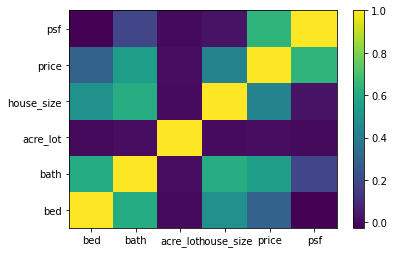

In [48]:
plot_df = df
plot_df['psf'] = plot_df['price'] / plot_df['house_size']
# plot the correlation matrix
vars_to_use = ['bed', 'bath', 'acre_lot', 'house_size', 'price', 'psf']  # pick vars
plt.pcolor(df[vars_to_use].corr())  # do the feature correlation plot

# fill in the indices
plt.yticks(np.arange(0.5, len(vars_to_use), 1), vars_to_use)
plt.xticks(np.arange(0.5, len(vars_to_use), 1), vars_to_use)
plt.colorbar()
plt.show()

The most notable part of this correlation matrix is that all elements are positively correlated with each other. This means that in general, that more expensive houses are larger, on bigger lots, are fancier, have more bedrooms, and more baths, assuming linear relationships. More of one of these items mean more of the others.

Amongst the correlations with price, Price per square foot, baths, bedrooms, house size, and lot size are in that order most to least correlated with price. This ordering. Another point of interest is that none of the variables have a statistically significant correlation with acre lot, indicating that it is independent of the other variables.
There is a very significant correlation between bed and bath, which seems to make inutitive sense, as having a significantly dispe\arate number of either of these relative to other would probably negatively impact the property's viability.
Additionally, we added the price per square foot variable (an industry marker for the relative "quality" of a property). It seems to be the most significant indicator of price. implying that higher quality homes are more expensive (which seems obvious), but this doesn't hold for house size, indicating that bigger is not actually better.

### How has price changed over time?

We already created violin plots by state for 2011 onwards, but let's do this same for the preceding decades from 1981 to 2001

In [49]:
df_2000s = df[(df.sold_date < dt.datetime(2011,1,1)) & (df.sold_date > dt.datetime(2000,1,1))]
df_90s = df[(df.sold_date < dt.datetime(2000,1,1)) & (df.sold_date > dt.datetime(1990,1,1))]
df_80s = df[(df.sold_date < dt.datetime(1990,1,1)) & (df.sold_date > dt.datetime(1980,1,1))]

In [50]:
print(len(recent_sold_homes))
print(len(df_2000s))
print(len(df_90s))
len(df_80s)

98715
83402
36054


12076

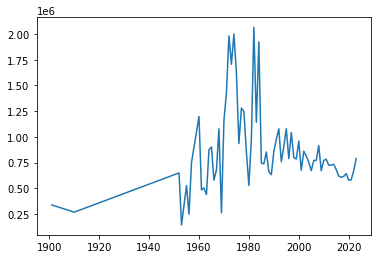

In [51]:
group_df = df.groupby(df.sold_date.dt.year).mean()
plt.plot(group_df.price)

In [52]:
recent_sold_homes.city.value_counts()

Philadelphia     3211
Staten Island    2141
Boston           1813
New York City    1807
Bronx            1611
                 ... 
Narrowsburg         1
Otisfield           1
Pipersville         1
Erwinna             1
Lyman               1
Name: city, Length: 1495, dtype: int64

In [53]:
df_2000s.city.value_counts()

Boston            3753
Staten Island     1773
Philadelphia      1456
Brooklyn          1248
Worcester         1180
                  ... 
Belle Terre          1
Lake Grove           1
Malverne             1
East Bangor          1
Blooming Grove       1
Name: city, Length: 1374, dtype: int64

In [54]:
import umap
from sklearn.preprocessing import StandardScaler
reducer = umap.UMAP()
data = df[['bath', 'bed', 'acre_lot', 'house_size']]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
embedding = reducer.fit_transform(scaled_data)
plt.scatter(embedding[:,0], embedding[:,1,], c=df.price_cat, cmap='Spectral', s=5)

Boston           1092
Brooklyn          974
Staten Island     855
Philadelphia      775
Bronx             547
                 ... 
Carversville        1
Paoli               1
Harvey Cedars       1
Townsend            1
North Baldwin       1
Name: city, Length: 1074, dtype: int64

UMAP(uniform manifold approximation projection), is a dimensionality reduction algorithm that, at a high level, constructs a graph weights on probability of connections existing between points in n dimensions and then optimizes a lower dimensional graph in m dimensions to be a similar as possible to its high dimensional counterpart. This is done based on the construction of a simplicial complex (basically trying to take a continuous geometry problem and breaking it down into combinatorial structures like points and lines) and mathematically there are guarantees of this preserving the topological structure (nerve theorem), assuming a uniform distribution on the manifold. Of course, this doesn't always hold true for real data, so UMAP uses the distance between the kth nearest neighbor as the radii for determining proximity in the graph. UMAP also constructs a fuzzy graph in the high dimensional stage by only assuming connectedness from a point and its closest neighbor and then implementing fuzzy decay in all the successive neighbors. This mathematical approach allows UMAP to do a much better job than T-SNE (for example), at preserving both local and global structure, rather than just local structure. The low dimensional projection is quite complex but essentially works by using the notion of lower dimensional euclidean space as distance and then using the min_disy hyperparameter to determine how closely to bunch different points together in lower dimensional space, as earlier we simply computed the distance to the nearest neighbor in high dimensional space, but that won't necessarily work on the lower dimensional manifold.



In [55]:
df_80s.city.value_counts()

Brooklyn         602
Philadelphia     441
New York City    254
Springfield      229
Staten Island    205
                ... 
Toughkenamon       1
Garnet Valley      1
Dresher            1
Belle Harbor       1
Harvey Cedars      1
Name: city, Length: 648, dtype: int64

As can be seen by the above that the outputs, there is a large variation in the locations which are preseent in the data between the decades. Due to the potential relative differences in local pricing (ie Manhattan, NY is much more expensive than Manhattan, Kansas) the trendlines in price changes will not reflect the actual changes in pricing.